In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, log_loss, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.combine import SMOTETomek, SMOTEENN

import xgboost as xgb

import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

from flaml import AutoML
from flaml.automl.data import get_output_from_log

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

In [171]:
df = pd.read_csv("weatherAUS.csv")
df.columns = df.columns.str.lower()
df = df.dropna().reset_index(drop=True)
df = df.drop("date", axis=1)
df.head()

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
0,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
2,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
3,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
4,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [172]:
X = df.drop("raintomorrow", axis=1).copy()
X.head()

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday
0,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No
1,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No
2,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No
3,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No
4,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No


In [173]:
X_encoded = pd.get_dummies(X, drop_first=True).astype(float)
X_encoded.head()

,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,...,winddir3pm_NW,winddir3pm_S,winddir3pm_SE,winddir3pm_SSE,winddir3pm_SSW,winddir3pm_SW,winddir3pm_W,winddir3pm_WNW,winddir3pm_WSW,raintoday_Yes
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [174]:
y = df["raintomorrow"].copy()
y.head()

0    No
1    No
2    No
3    No
4    No
Name: raintomorrow, dtype: object

In [175]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)
y_encoded

array([0, 0, 0, ..., 0, 0, 0])

In [176]:
df_encoding = pd.DataFrame({
    "Encoded_Label": range(len(label_encoder.classes_)),
    "Original_Label": label_encoder.classes_
})
df_encoding

,Encoded_Label,Original_Label
0,0,No
1,1,Yes


In [177]:
random_state = 42

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=random_state, test_size=0.3, stratify=y_encoded)

print(f"Training dataset\t: {len(X_train)}\t({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)}\t({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 39494	(70%)
Testing dataset		: 16926	(30%)


In [179]:
smoteenn = SMOTEENN(random_state=random_state)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [11]:
sample_weight = compute_sample_weight(
    class_weight="balanced",
    y=y_train
)

# Other Models

In [124]:
def evaluation(model):
    print(f"Training accuracy\t: {accuracy_score(y_train_smoteenn, model.predict(X_train_smoteenn))}")
    print(f"Testing accuracy\t: {accuracy_score(y_test, model.predict(X_test))}")

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test), display_labels=label_encoder.classes_, cmap="Blues", ax=ax)

    wrapper = textwrap.TextWrapper(width=18)

    x_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_xticklabels()]
    ax.set_xticklabels(x_labels, rotation=90)

    y_labels = ["\n".join(wrapper.wrap(label.get_text())) for label in ax.get_yticklabels()]
    ax.set_yticklabels(y_labels)

    plt.show()

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [123]:
log_model = LogisticRegression(random_state=random_state, max_iter=5000)
log_model.fit(X_train_smoteenn, y_train_smoteenn)

LogisticRegression(max_iter=5000, random_state=42)

Training accuracy	: 0.8898752250294866
Testing accuracy	: 0.7417582417582418


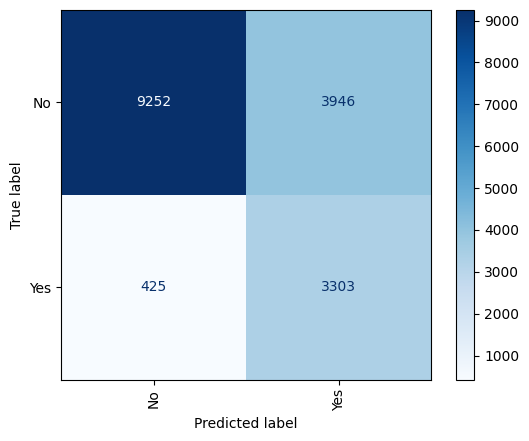

In [125]:
evaluation(log_model)

In [126]:
rf_model = RandomForestClassifier(random_state=random_state)
rf_model.fit(X_train_smoteenn, y_train_smoteenn)

RandomForestClassifier(random_state=42)

Training accuracy	: 1.0
Testing accuracy	: 0.8082240340304856


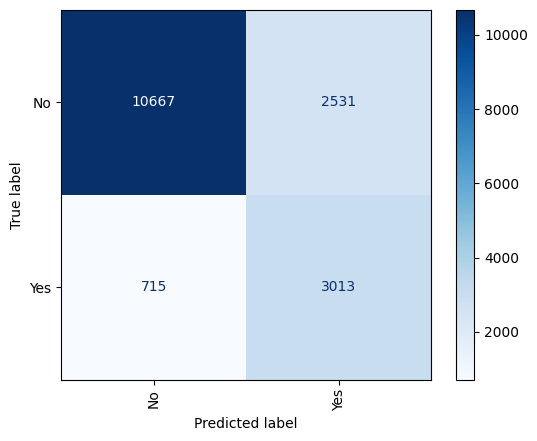

In [127]:
evaluation(rf_model)

# Default

In [101]:
# default_xgb_model = xgb.XGBClassifier(
#     objective="binary:logistic",
#     missing=np.nan,
#     seed=random_state,
#     eval_metric="aucpr",
#     early_stopping_rounds=10
# )
# default_xgb_model.fit(
#     X_train,
#     y_train,
#     verbose=True,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
#     sample_weight=sample_weight
# )

In [102]:
default_xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    missing=np.nan,
    seed=random_state,
    eval_metric="aucpr",
    early_stopping_rounds=10
)
default_xgb_model.fit(
    X_train_smoteenn,
    y_train_smoteenn,
    verbose=True,
    eval_set=[(X_train_smoteenn, y_train_smoteenn), (X_test, y_test)]
)

[0]	validation_0-aucpr:0.96797	validation_1-aucpr:0.62250
[1]	validation_0-aucpr:0.97557	validation_1-aucpr:0.65274
[2]	validation_0-aucpr:0.97860	validation_1-aucpr:0.66501
[3]	validation_0-aucpr:0.98051	validation_1-aucpr:0.66806
[4]	validation_0-aucpr:0.98256	validation_1-aucpr:0.67066
[5]	validation_0-aucpr:0.98422	validation_1-aucpr:0.67740
[6]	validation_0-aucpr:0.98577	validation_1-aucpr:0.68717
[7]	validation_0-aucpr:0.98700	validation_1-aucpr:0.69013
[8]	validation_0-aucpr:0.98867	validation_1-aucpr:0.69019
[9]	validation_0-aucpr:0.98963	validation_1-aucpr:0.69271
[10]	validation_0-aucpr:0.99050	validation_1-aucpr:0.70163
[11]	validation_0-aucpr:0.99126	validation_1-aucpr:0.70541
[12]	validation_0-aucpr:0.99177	validation_1-aucpr:0.70649
[13]	validation_0-aucpr:0.99219	validation_1-aucpr:0.71112
[14]	validation_0-aucpr:0.99269	validation_1-aucpr:0.71114
[15]	validation_0-aucpr:0.99316	validation_1-aucpr:0.71175
[16]	validation_0-aucpr:0.99363	validation_1-aucpr:0.71564
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Training accuracy	: 0.9831564135990233
Testing accuracy	: 0.8229942100909843


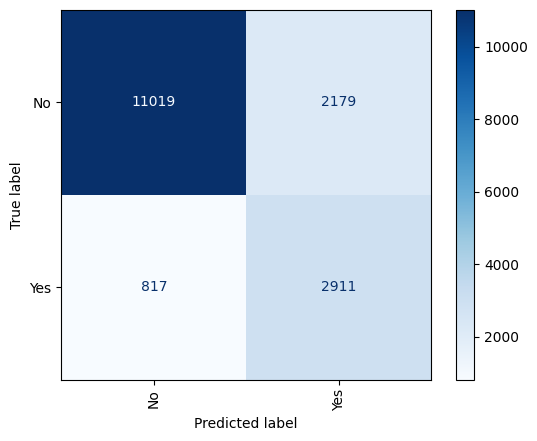

In [128]:
evaluation(default_xgb_model)

# AutoML

In [105]:
# automl_xgb_model = AutoML()

# settings = {
#     "time_budget": -1,
#     "metric": "ap",
#     "estimator_list": ["xgboost"],
#     "task": "classification",
#     "seed": 42,
#     "sample_weight": sample_weight
# }

# automl_xgb_model.fit(X_train=X_train, y_train=y_train, **settings)

In [106]:
automl_xgb_model = AutoML()

settings = {
    "time_budget": -1,
    "metric": "ap",
    "estimator_list": ["xgboost"],
    "task": "classification",
    "seed": 42,
}

automl_xgb_model.fit(X_train=X_train_smoteenn, y_train=y_train_smoteenn, **settings)

[flaml.automl.logger: 10-25 14:37:51] {1679} INFO - task = classification
[flaml.automl.logger: 10-25 14:37:51] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-25 14:37:51] {1788} INFO - Minimizing error metric: 1-ap
[flaml.automl.logger: 10-25 14:37:51] {1811} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
[flaml.automl.logger: 10-25 14:37:52] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 10-25 15:03:02] {2627} INFO - retrain xgboost for 1510.6s
[flaml.automl.logger: 10-25 15:03:02] {2630} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.590641168068946, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,

In [107]:
automl_xgb_model.best_config

{'n_estimators': 13499,
 'max_leaves': 60,
 'min_child_weight': 0.008494221584011285,
 'learning_rate': 0.006955765856675575,
 'subsample': 0.5965241023754743,
 'colsample_bylevel': 0.590641168068946,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.2522240954379289,
 'reg_lambda': 5.351809144038808}

Training accuracy	: 1.0
Testing accuracy	: 0.8311473472763795


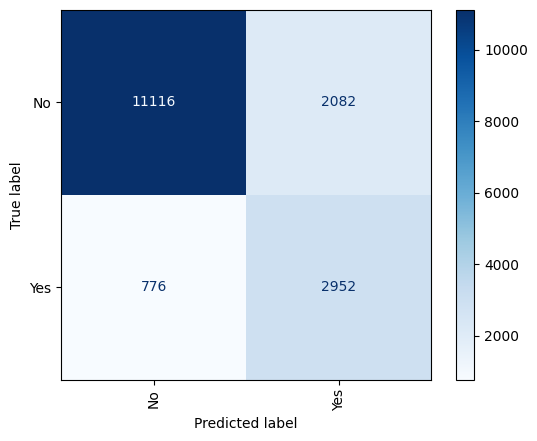

In [129]:
evaluation(automl_xgb_model)

# Optuna

In [134]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 20000),
        # "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "seed": random_state,
        # "sample_weight": sample_weight,
        "eval_metric": "aucpr",
        "early_stopping_rounds": 10
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_smoteenn, y_train_smoteenn, eval_set=[(X_test, y_test)], verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)

    # proba_predictions = model.predict_proba(X_test)[:, 1]
    # aucpr = average_precision_score(y_test, proba_predictions)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2023-10-25 18:28:01,745] A new study created in memory with name: no-name-df632fe9-e894-407e-b2c3-21021e1e69fb


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-25 18:28:06,133] Trial 0 finished with value: 0.6468746307455985 and parameters: {'n_estimators': 10980, 'learning_rate': 0.015326811750918167, 'lambda': 0.10212738272509776, 'alpha': 4.7969850720919726e-06, 'max_depth': 9, 'subsample': 0.6483876497525956, 'colsample_bytree': 0.37372958538462314, 'min_child_weight': 14}. Best is trial 0 with value: 0.6468746307455985.
[I 2023-10-25 18:28:10,666] Trial 1 finished with value: 0.7520973650005908 and parameters: {'n_estimators': 7946, 'learning_rate': 0.043801146335628746, 'lambda': 0.0004913998305083257, 'alpha': 0.00012034654644686797, 'max_depth': 9, 'subsample': 0.4580520536239927, 'colsample_bytree': 0.24111149748400146, 'min_child_weight': 6}. Best is trial 1 with value: 0.7520973650005908.
[I 2023-10-25 18:28:12,743] Trial 2 finished with value: 0.22025286541415573 and parameters: {'n_estimators': 5238, 'learning_rate': 0.004228676330852865, 'lambda': 2.344266906490804e-07, 'alpha': 0.00024396363157013916, 'max_depth': 2,

In [158]:
# def objective(trial):
#     pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-aucpr")

#     params = {
#         "objective": "binary:logistic",
#         "n_estimators": trial.suggest_int("n_estimators", 1000, 20000),
#         "verbosity": 0,
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         "max_depth": trial.suggest_int("max_depth", 1, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
#         "seed": random_state,
#         "eval_metric": "aucpr",
#         "early_stopping_rounds": 10,
#         "callbacks": [pruning_callback]
#     }

#     model = xgb.XGBClassifier(**params)
#     model.fit(X_train_smoteenn, y_train_smoteenn, eval_set=[(X_test, y_test)], verbose=False)

#     pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, pred)

#     return accuracy

# study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
# study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2023-10-25 20:49:29,719] A new study created in memory with name: no-name-d5e1501d-1670-4aca-9d01-c660a376cbb4


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-25 20:49:34,859] Trial 0 finished with value: 0.22025286541415573 and parameters: {'n_estimators': 8982, 'learning_rate': 0.0011038671086455155, 'lambda': 2.194313693727362e-05, 'alpha': 0.00021201974240486117, 'max_depth': 8, 'subsample': 0.7766438028855067, 'colsample_bytree': 0.5856495578097443, 'min_child_weight': 8}. Best is trial 0 with value: 0.22025286541415573.
[I 2023-10-25 20:49:37,151] Trial 1 finished with value: 0.29823939501358854 and parameters: {'n_estimators': 12486, 'learning_rate': 0.006171213175242307, 'lambda': 0.00016664506566514854, 'alpha': 1.824621646883045e-06, 'max_depth': 3, 'subsample': 0.12472960896895681, 'colsample_bytree': 0.5371922947551703, 'min_child_weight': 18}. Best is trial 1 with value: 0.29823939501358854.
[I 2023-10-25 20:49:39,831] Trial 2 finished with value: 0.6504194730001182 and parameters: {'n_estimators': 14829, 'learning_rate': 0.02197187355527405, 'lambda': 0.08067138043983552, 'alpha': 2.507345056495916e-07, 'max_depth': 

In [159]:
print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

Best hyperparameters: {'n_estimators': 4714, 'learning_rate': 0.09064580973959814, 'lambda': 0.008688844793524598, 'alpha': 3.3069551687151934e-06, 'max_depth': 7, 'subsample': 0.6070079287723771, 'colsample_bytree': 0.8487732564813126, 'min_child_weight': 11}
Best score: 0.825593761077632


In [160]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.220253,2023-10-25 20:49:29.795592,2023-10-25 20:49:34.854080,0 days 00:00:05.058488,2.120197e-04,0.585650,2.194314e-05,0.001104,8,8,8982,0.776644,COMPLETE
1,1,0.298239,2023-10-25 20:49:34.867567,2023-10-25 20:49:37.149754,0 days 00:00:02.282187,1.824622e-06,0.537192,1.666451e-04,0.006171,3,18,12486,0.124730,COMPLETE
2,2,0.650419,2023-10-25 20:49:37.162290,2023-10-25 20:49:39.828982,0 days 00:00:02.666692,2.507345e-07,0.263593,8.067138e-02,0.021972,1,17,14829,0.907391,COMPLETE
3,3,0.220253,2023-10-25 20:49:39.842880,2023-10-25 20:49:42.101268,0 days 00:00:02.258388,5.132293e-08,0.374975,4.619836e-07,0.001819,5,17,16433,0.577402,COMPLETE
4,4,0.786246,2023-10-25 20:49:42.112888,2023-10-25 20:49:57.484302,0 days 00:00:15.371414,4.366920e-08,0.998927,1.649342e-01,0.019104,9,14,18595,0.147873,COMPLETE
5,5,0.650514,2023-10-25 20:49:57.498241,2023-10-25 20:49:58.368971,0 days 00:00:00.870730,3.117038e-03,0.201837,6.638520e-05,0.001747,3,16,12713,0.181935,PRUNED
6,6,0.581547,2023-10-25 20:49:58.380900,2023-10-25 20:49:59.194085,0 days 00:00:00.813185,2.720142e-07,0.149357,1.074465e-04,0.048434,1,4,9702,0.817832,PRUNED
7,7,0.777679,2023-10-25 20:49:59.208830,2023-10-25 20:50:14.233957,0 days 00:00:15.025127,1.719958e-03,0.684264,1.297270e-04,0.015567,9,13,7129,0.747389,COMPLETE
8,8,0.670286,2023-10-25 20:50:14.248800,2023-10-25 20:50:15.548956,0 days 00:00:01.300156,7.292887e-05,0.174503,2.104305e-04,0.056886,8,15,2649,0.117725,PRUNED
9,9,0.657432,2023-10-25 20:50:15.561196,2023-10-25 20:50:16.749078,0 days 00:00:01.187882,4.118595e-08,0.240538,2.524778e-04,0.001548,5,11,11367,0.224596,PRUNED


C:\Users\User\AppData\Local\Temp\ipykernel_14436\3324289224.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

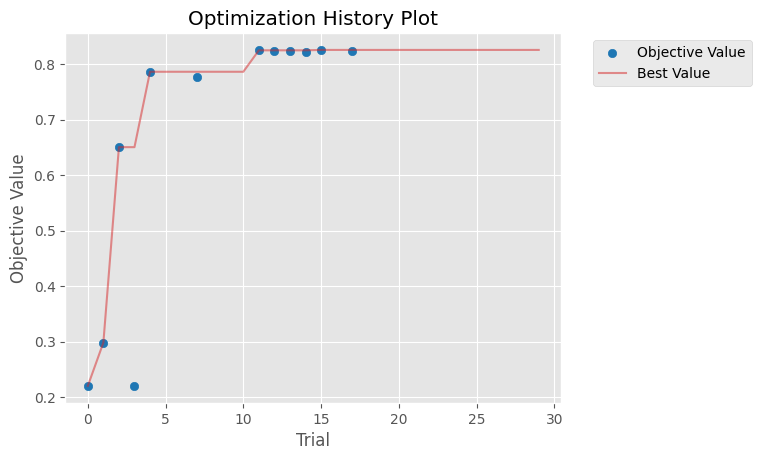

In [161]:
plot_optimization_history(study)

C:\Users\User\AppData\Local\Temp\ipykernel_14436\3836449081.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

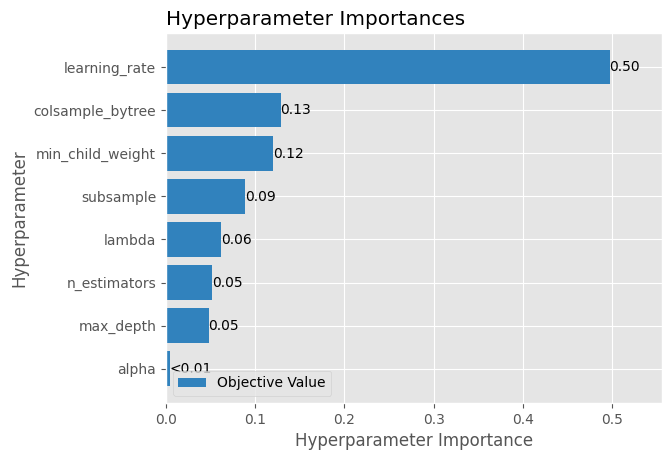

In [162]:
plot_param_importances(study)

In [163]:
optuna_xgb_model = xgb.XGBClassifier(**study.best_params)
optuna_xgb_model.fit(X_train_smoteenn, y_train_smoteenn, verbose=True)

XGBClassifier(alpha=3.3069551687151934e-06, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8487732564813126, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.008688844793524598,
              learning_rate=0.09064580973959814, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=11, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4714, n_jobs=None, ...)

Training accuracy	: 1.0
Testing accuracy	: 0.8283705541770058


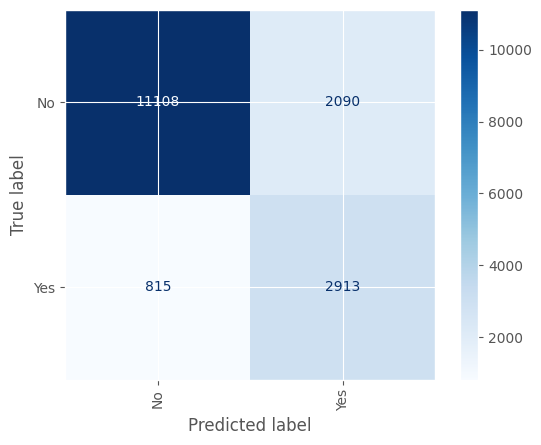

In [164]:
evaluation(optuna_xgb_model)